# Adding geographical coordinates

We will map an airport's geographical coordinates to weather data for the region using the 'Meteostat' library

First we will install the meteostat library and do the usual imports

In [8]:
# %pip install meteostat

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from meteostat import Point, Daily, Hourly

Get the current list of airports

In [2]:
df19 = pd.read_csv('../Jan_2019_ontime.csv')
df20 = pd.read_csv('../Jan_2019_ontime.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../Jan_2019_ontime.csv'

Find the unique airports so we can identify their coordinates.

It was previously checked that both 2019 and 2020 have the same airports.
In addition, both the ORIGIN and DEST columns share the same airports. 
Thus we can assume that it is fine to use the ORIGIN column from the 2019 dataset

In [11]:
# Get unique airports (The length of unique values in ORIGIN and DEST is the same)
airports = pd.concat([df19.ORIGIN, df20.ORIGIN, df19.DEST, df20.DEST]).unique()

Get data from https://datahub.io/core/airport-codes with the geographical location of airports

In [12]:
# https://datahub.io/core/airport-codes
df_geo = pd.read_csv('airport-codes.csv')  

In [13]:
df_geo.sample(1)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
36974,MY97,small_airport,Nielsen's Airport,990.0,NaN,US,US-MN,Farmington,MY97,NaN,MY97,"-93.12689971923828, 44.597999572753906"


Now get the geographical location of all the airports in the 'df' dataset.

Keep only the relevant columns:
- iata_code
- coordinates
- elevation_ft

In [14]:
# Get coordinates for the airports in the dataset
coords = df_geo[df_geo.iata_code.isin(airports)][['iata_code', 'coordinates', 'elevation_ft']]

We see that the coordinates are contained as a string and in the order of (longitude, latitude). So we will have to extract that information into two columns: __lng__ and __lat__. Moreover, the elevation is in feet, but the meteostat uses meters, so we will also convert this value and save it in the column __elevation_m__.

In [15]:
# Separate longitude and latitude and dtypes
coords['lng'] = coords.coordinates.apply(lambda x: x.split(',')[0]).astype(float)
coords['lat'] = coords.coordinates.apply(lambda x: x.split(',')[1]).astype(float)

coords['elevation_m'] = coords.elevation_ft.astype(float) * 0.3048  # Conversion from feet to meters

In [16]:
# Drop old coordinate column
coords = coords.drop('coordinates', axis=1)
coords.columns

Index(['iata_code', 'elevation_ft', 'lng', 'lat', 'elevation_m'], dtype='object')

Now we have the coordinates for each airport. From this we can find the weather information.

# Adding weather data

In this section we will add the weather data for each airport and the finally merge it to our dataset.

First we define a function which helps us find the nearest station of the geographical coordinates to increase weather data accuracy. The default radius parameter is 35km, but some stations are further away than this, and others are found closer.

We set the minimum radius to 10km, as a lower radius would result in too many NaN values of the weather data. Then we increment by 1km if no data is found within the current radius.

The acquired data is described at https://dev.meteostat.net/formats.html#time-format

In [20]:
# Set time period
start = datetime(2019, 1, 1)
end = datetime(2019, 1, 31)

# Find minimum radius for most accurate temperatures. Must be at least 10km from point, and snow can't be all nan
def find_min_radius(lat, lng, alt=None):   
    df = pd.DataFrame()
    
    step = 1000
    radius = 10000
    while True:
        if radius % 10000 == 0:
            print('Radius = ', radius)
        
        radius += step       
        
        point = Point(lat, lng, alt)
        point.radius = radius
        
        try:
            print(start)
            data = Daily(point, start, end)
            
            # Fetch data
            data = data.normalize()
            data = data.interpolate()
            df = data.fetch()
            
            # Stop if non-empty data
            if (len(df) != 0) or radius >= 100000:  # Max 100 km range
                radius = 10000
                break;
                
        except Exception:
            pass
    
    return df
        

In [23]:
# find_min_radius(42.74829864501953, -73.80169677734375, 0)

Now we create a dictionary with each airport and it's corresponding weather data for January 

In [19]:
def create_weather_dict():
    """
    Create a dictionary of weather data at airports for 2019 and 2020.
    """
    #### 2019 ####

    # Set time period
    start = datetime(2019, 1, 1)
    end = datetime(2019, 1, 31)

    weather_dict = {}

    for idx, row in coords.iterrows():
        print('Finding weather data for', row.iata_code)
        df = find_min_radius(row.lat, row.lng, row.elevation_m)
        weather_dict[row.iata_code] = df

    save_dict = {}

    for key, val in weather_dict.items():
        save_dict[key] = val.to_dict(orient='records')

    with open('weather_dict2019.json', 'w') as outfile:
        json.dump(save_dict, outfile)

    #### 2020 ####
    # Set time period
    start = datetime(2020, 1, 1)
    end = datetime(2020, 1, 31)

    weather_dict = {}

    for idx, row in coords.iterrows():
        print('Finding weather data for', row.iata_code)
        df = find_min_radius(row.lat, row.lng, row.elevation_m)
        weather_dict[row.iata_code] = df

    save_dict = {}

    for key, val in weather_dict.items():
        save_dict[key] = val.to_dict(orient='records')

    with open('weather_dict2020.json', 'w') as outfile:
        json.dump(save_dict, outfile)
        

In [24]:
%%time
import json

# ONLY UNCOMMENT IF YOU HATE YOUR LIFE
# create_weather_dict()

Wall time: 0 ns


Load the json file

In [16]:
def load_weather_dict(year):
    out_dict = {}
    
    with open(f'weather_dict{year}.json', 'r') as infile:
        data = json.load(infile)
        
        for key, val in data.items():
            out_dict[key] = pd.DataFrame(val)
            
    return out_dict

In [17]:
weather_2019 = load_weather_dict(2019)
weather_2020 = load_weather_dict(2020)

## Units and parameters

We will shortly explain the parameters and units of the weather data https://dev.meteostat.net/formats.html#meteorological-parameters

The parameters of the weather data are:

| Code  | Meaning                |
| ----- | ---------------------- |
| TAVG  | Average Temperature    |
| TMIN  | Minimum Temperature    |
| TMAX  | Maximum Temperature    |
| PRCP  | Total Precipitation    |
| SNOW  | Snow Depth             |
| WDIR  | Wind Direction         |
| WSPD  | Wind Speed             |
| WPGT  | Wind Peak Gust         |
| PRES  | Sea-Level Air Pressure |
| TSUN  | Total Sunshine Duration|

The units of the weather data are:

| Parameter(s) | Unit |
| ------------ | ---- |
| Temperature  |  °C  |
| Precipitation| mm   |
| Air pressure | hPa  |
| Wind Speed   | km/h |
| Sunshine duration   | Minutes, Hours |

# Merge the data

In this section, we will merge the weather data with the dataset

In [18]:
df19 = pd.read_csv('../Jan_2019_ontime.csv').drop('Unnamed: 21', axis=1)
df20 = pd.read_csv('../Jan_2020_ontime.csv').drop('Unnamed: 21', axis=1)

Define helper functions to map the airport and the day to the corresponding weather data

In [19]:
weather_columns = ['tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres']

# Helper function to prefix column names
def rename_map(column):  
    out_dict = {'iata_code': column}
    
    for col in weather_columns:
        out_dict[col] = f'{column}_{col}'
    
    return out_dict

Create a dataframe for merging

In [20]:
def get_weather_df(weather_dict):
    weather_df = pd.DataFrame(
        columns=['iata_code', 'DAY_OF_MONTH', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres']
    )
    for airport in airports:
        temp_df = weather_2019[airport][weather_columns]
        temp_df['iata_code'] = airport
        temp_df = temp_df.reset_index()
        temp_df = temp_df.rename({'index': 'DAY_OF_MONTH'}, axis=1)
        temp_df['DAY_OF_MONTH'] += 1
        weather_df = pd.concat([weather_df, temp_df])
        
    return weather_df.reset_index(drop=True)

Merge the weather data with the original data on both the destination and origin airport

In [21]:
weather_df_2019 = get_weather_df(weather_2019)

<ipython-input-20-4d4314cfe007>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['iata_code'] = airport


In [22]:
df19_weather = df19.merge(weather_df_2019.rename(rename_map('ORIGIN'), axis=1), on=['ORIGIN', 'DAY_OF_MONTH'])
df19_weather = df19_weather.merge(weather_df_2019.rename(rename_map('DEST'), axis=1), on=['DEST', 'DAY_OF_MONTH'])

In [23]:
df19_weather.shape

(583985, 35)

In [24]:
df19.shape

(583985, 21)

The shapes add up, as there are no lost rows during the merge

In [25]:
df19_weather.isna().sum()

DAY_OF_MONTH                  0
DAY_OF_WEEK                   0
OP_UNIQUE_CARRIER             0
OP_CARRIER_AIRLINE_ID         0
OP_CARRIER                    0
TAIL_NUM                   2543
OP_CARRIER_FL_NUM             0
ORIGIN_AIRPORT_ID             0
ORIGIN_AIRPORT_SEQ_ID         0
ORIGIN                        0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST                          0
DEP_TIME                  16352
DEP_DEL15                 16355
DEP_TIME_BLK                  0
ARR_TIME                  17061
ARR_DEL15                 18022
CANCELLED                     0
DIVERTED                      0
DISTANCE                      0
ORIGIN_tavg                2919
ORIGIN_tmin                2912
ORIGIN_tmax                2912
ORIGIN_prcp               26856
ORIGIN_snow              181307
ORIGIN_wspd                3952
ORIGIN_pres               24313
DEST_tavg                  2923
DEST_tmin                  2916
DEST_tmax                  2916
DEST_prc

We see that there are A LOT of missing values, around 30% of the dataset is missing in the snow column!

In [26]:
weather_df_2020 = get_weather_df(weather_2020)

<ipython-input-20-4d4314cfe007>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['iata_code'] = airport


In [27]:
df20_weather = df20.merge(weather_df_2020.rename(rename_map('ORIGIN'), axis=1), on=['ORIGIN', 'DAY_OF_MONTH'])
df20_weather = df20_weather.merge(weather_df_2020.rename(rename_map('DEST'), axis=1), on=['DEST', 'DAY_OF_MONTH'])

In [28]:
df20_weather.shape

(606497, 35)

In [29]:
df20.shape

(607346, 21)

Around 900 rows are lost in this merge. We will investigate the impact of these lost rows. First let's observe the total amount of delays and cancellations

In [30]:
df20.loc[:, ['CANCELLED', 'ARR_DEL15', 'DEP_DEL15']].sum()

CANCELLED     6928.0
ARR_DEL15    82285.0
DEP_DEL15    81884.0
dtype: float64

Relative to the total rows in the dataset, there are few cancellations but plenty of delayed flights

In [31]:
df20.loc[~df20.index.isin(df20_weather.index), ['CANCELLED', 'ARR_DEL15', 'DEP_DEL15']].sum()

CANCELLED      0.0
ARR_DEL15    108.0
DEP_DEL15     86.0
dtype: float64

In the lost rows we have no cancellations and only few delayed flights, thus we can see this as being negible for the overall problem.

In [32]:
df20_weather.isna().sum()

DAY_OF_MONTH                  0
DAY_OF_WEEK                   0
OP_UNIQUE_CARRIER             0
OP_CARRIER_AIRLINE_ID         0
OP_CARRIER                    0
TAIL_NUM                    698
OP_CARRIER_FL_NUM             0
ORIGIN_AIRPORT_ID             0
ORIGIN_AIRPORT_SEQ_ID         0
ORIGIN                        0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST                          0
DEP_TIME                   6638
DEP_DEL15                  6671
DEP_TIME_BLK                  0
ARR_TIME                   7046
ARR_DEL15                  8043
CANCELLED                     0
DIVERTED                      0
DISTANCE                      0
ORIGIN_tavg                3232
ORIGIN_tmin                3225
ORIGIN_tmax                3225
ORIGIN_prcp               28496
ORIGIN_snow              192121
ORIGIN_wspd                4337
ORIGIN_pres               25972
DEST_tavg                  3236
DEST_tmin                  3229
DEST_tmax                  3229
DEST_prc

Again there are many missing values...

## Verification

We now check that the data after merging is correct

In [33]:
df19_weather[['DAY_OF_MONTH', 'ORIGIN', 'DEST', 'ORIGIN_tavg', 'DEST_tavg']]

,DAY_OF_MONTH,ORIGIN,DEST,ORIGIN_tavg,DEST_tavg
0,1,GNV,ATL,20.1,15.9
1,1,GNV,ATL,20.1,15.9
2,1,GNV,ATL,20.1,15.9
3,1,GNV,ATL,20.1,15.9
4,1,MSP,ATL,-14.1,15.9
...,...,...,...,...,...
583980,31,WRG,PSG,3.3,NaN
583981,31,KTN,WRG,5.3,3.3
583982,31,PSG,WRG,NaN,3.3
583983,31,GUM,SPN,26.3,25.6


We see that for the GNV airport, the average temperature is 20.1 C, and for ATL the temperature was 15.9 C

In [34]:
weather_2019['GNV'].loc[0]

tavg      20.1
tmin      13.9
tmax      27.8
prcp       0.0
snow       0.0
wdir     206.4
wspd       4.0
wpgt       NaN
pres    1021.9
tsun       NaN
Name: 0, dtype: float64

In [35]:
weather_2019['ATL'].loc[0]

tavg      15.9
tmin      12.9
tmax      17.9
prcp       NaN
snow       NaN
wdir       NaN
wspd       2.5
wpgt       NaN
pres    1016.6
tsun       NaN
Name: 0, dtype: float64

It adds up

# Modelling missing values

Based on previous exploratory analysis, it is clear that weather data might have a significant impact on the flight delays and cancellations

Therefore, an attempt at predicting the missing values is done to increase the quality of the dataset and hopefully improve the performance of the predictive models

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

As snow is one of the main reasons why planes cannot land or take off, and it is the column with most missing values, the models will try to predict the amount of snow based on other columns. 

In [38]:
target = ['snow']

Initially we choose a set of features based on intuition and common knowledge on which columns could explain the presence of snow

In [39]:
features = ['tavg', 'tmin', 'tmax', 'wspd', 'prcp', 'pres']

We will use both 2019 and 2020 data, so we concatenate the two dataframes

In [40]:
weather_df_total = pd.concat([weather_df_2019, weather_df_2020]).reset_index(drop=True)
weather_df_total.shape

(21452, 9)

We quickly inspect the distributions of the features

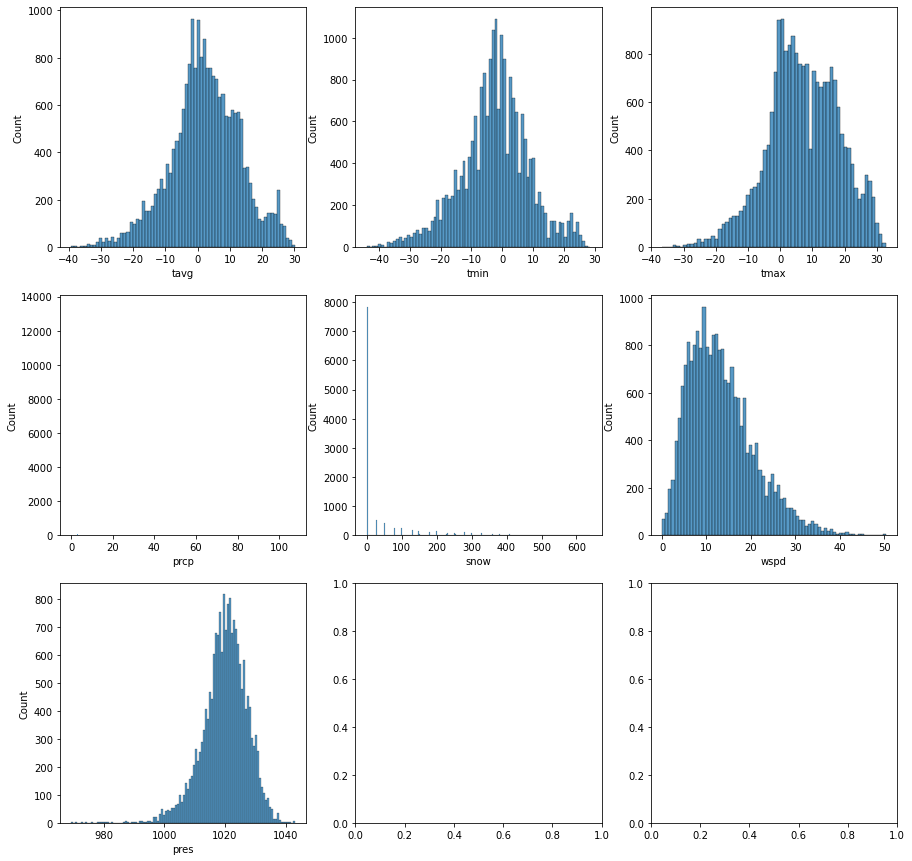

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

sns.histplot(weather_df_total, x='tavg', ax=axs[0,0])
sns.histplot(weather_df_total, x='tmin', ax=axs[0,1])
sns.histplot(weather_df_total, x='tmax', ax=axs[0,2])
sns.histplot(weather_df_total, x='prcp', ax=axs[1,0])
sns.histplot(weather_df_total, x='snow', ax=axs[1,1])
sns.histplot(weather_df_total, x='wspd', ax=axs[1,2])
sns.histplot(weather_df_total, x='pres', ax=axs[2,0])

plt.show()

<AxesSubplot:>

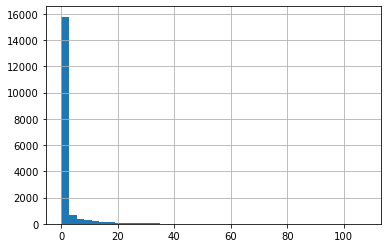

In [42]:
weather_df_total['prcp'].hist(bins=40)

They seem to roughly follow a normal distribution, with the exception of precipitation having a lot of 0 values.

We know that there are missing values, as some weather stations do not record all data. To predict the snow values, we have to remove these missing values. To avoid making assumptions on the features, we drop the missing rows, as predicting the values of snow in itself is a large assumption

In [43]:
clean_df = weather_df_total[features + target].dropna()
clean_df.shape

(9966, 7)

In [44]:
X = clean_df[features].to_numpy()
y = clean_df[target].to_numpy()

## Feature selection

To select some relevant features for filling out the missing snow values, we use the Shapley values to see the importance of each feature. Initially we choose a larger set of features that would make sense.

In [45]:
import xgboost as xgb
import shap

In [46]:
xgb_model = xgb.XGBRegressor().fit(X, y)  # Using default parameters

In [47]:
explainer = shap.Explainer(xgb_model, X, feature_names=features)
shap_values = explainer(X)

 98%|===================| 9752/9966 [00:19<00:00]        

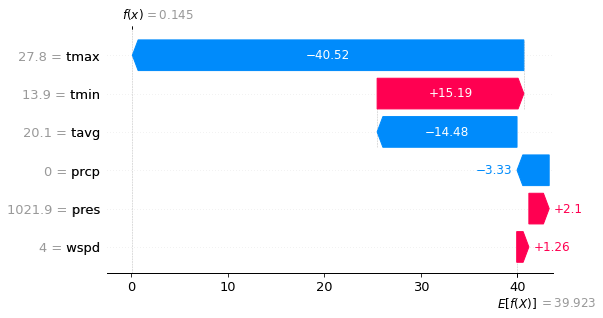

In [48]:
shap.plots.waterfall(shap_values[0])

From this we can now define the most relevant features

In [49]:
features = ['tmax', 'tavg', 'tmin']
target = ['snow']

And redefine X and y

In [50]:
clean_df2 = weather_df_total[features + target].dropna()

X = clean_df2[features].to_numpy()
y = clean_df2[target].to_numpy()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

## Scaling

To have equal importance for all features, we standardize the data

In [52]:
from sklearn.preprocessing import StandardScaler

We only scale on the test set to avoid information leaking to the validation or test set

In [53]:
sc = StandardScaler().fit(X_train)

In [54]:
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [55]:
X_train.mean(), X_train.std()

(1.9749829833472978e-16, 1.0)

In [56]:
X_val.mean(), X_val.std()

(-0.015162456219813682, 0.9900294159709723)

We define a function to evaluate models

In [57]:
def eval_model(X, y, model):
    y_pred = model.predict(X)
    
    print('MAE: ', mean_absolute_error(y, y_pred))
    print("MSE: ", mean_squared_error(y, y_pred))
    print("R2: ", r2_score(y, y_pred))

## Linear regression

We will try with a simple linear regression

In [58]:
from sklearn.linear_model import LinearRegression

In [59]:
lr = LinearRegression().fit(X_train, y_train)

In [60]:
eval_model(X_train, y_train, lr)

MAE:  45.5739693494986
MSE:  4429.961476705218
R2:  0.3525049067747881


In [61]:
eval_model(X_val, y_val, lr)

MAE:  46.03849994508904
MSE:  4570.380017769114
R2:  0.34671671830601314


In [62]:
eval_model(X_test, y_test, lr)

MAE:  45.976249548709625
MSE:  4579.340863534511
R2:  0.35295804713392354


Generally the performance is not great from the linear model, it shows poor performance and probably underfits the data

In [63]:
y.mean()

36.181895896656535

The mean of the target is 36.2 and the absolute error of the model is greater than this. It is probably not a good idea to use this model for filling in the missing values

## MLP Regressor

Next we extend the problem to try with the MLP regressor

In [64]:
from sklearn.neural_network import MLPRegressor

In [65]:
params = {
    'hidden_layer_sizes': (20, 10, 5), 
    'activation': 'relu', 
    'solver': 'adam', 
    'max_iter': 5000, 
    'alpha': 0.00010
}

In [66]:
mlp = MLPRegressor(**params)
mlp.fit(X_train, y_train.ravel())

MLPRegressor(hidden_layer_sizes=(20, 10, 5), max_iter=5000)

In [67]:
eval_model(X_train, y_train, mlp)

MAE:  29.24756068212208
MSE:  3391.3392402666764
R2:  0.5043127284330309


In [68]:
eval_model(X_val, y_val, mlp)

MAE:  30.561724882093607
MSE:  3627.2983027058704
R2:  0.48151940765061574


In [69]:
eval_model(X_test, y_test, mlp)

MAE:  30.093827943458454
MSE:  3645.125469591688
R2:  0.48495882429986625


The absolute error is surely smaller, however the model shows small signs of overfitting, but nothing too significant.

This model could definitely be a candidate for filling out the missing values.

## Neural net

Finally, we will try building our own neural net using the keras library.

In [70]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import regularizers

import matplotlib.pyplot as plt

The architecture was created by training the model on the train data and testing the results on the validation data.

In [71]:
# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(20, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
x = Dense(10, activation='relu')(inputs)
x = Dropout(.2)(inputs)
x = Dense(5, activation='relu')(inputs)
predictions = Dense(1, activation='linear')(x)

# This creates a model that includes
# the Input layer and three Dense layers
nn_model = Model(inputs=inputs, outputs=predictions)

nn_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'mean_absolute_error'])

callback = EarlyStopping(monitor='loss', patience=3)

history = nn_model.fit(X_train, y_train,
              batch_size=1000,
              epochs=1000,
              verbose=1,
              validation_data=(X_val, y_val),
              callbacks=[callback])  # starts training

Epoch 1/1000
5/5 [==============================] - 3s 197ms/step - loss: 7980.6199 - mean_squared_error: 7980.6199 - mean_absolute_error: 35.3077 - val_loss: 8417.8984 - val_mean_squared_error: 8417.8984 - val_mean_absolute_error: 37.0800
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 8412.1330 - mean_squared_error: 8412.1331 - mean_absolute_error: 36.7309 - val_loss: 8412.0967 - val_mean_squared_error: 8412.0967 - val_mean_absolute_error: 37.0540
Epoch 3/1000
5/5 [==============================] - 0s 10ms/step - loss: 8366.0060 - mean_squared_error: 8366.0060 - mean_absolute_error: 36.6535 - val_loss: 8406.4668 - val_mean_squared_error: 8406.4668 - val_mean_absolute_error: 37.0291
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 7925.2758 - mean_squared_error: 7925.2758 - mean_absolute_error: 35.8761 - val_loss: 8401.0137 - val_mean_squared_error: 8401.0137 - val_mean_absolute_error: 37.0056
Epoch 5/1000
5/5 [=========================

5/5 [==============================] - 0s 9ms/step - loss: 7957.0379 - mean_squared_error: 7957.0379 - mean_absolute_error: 35.3000 - val_loss: 8106.0444 - val_mean_squared_error: 8106.0444 - val_mean_absolute_error: 36.4475
Epoch 70/1000
5/5 [==============================] - 0s 9ms/step - loss: 7549.2747 - mean_squared_error: 7549.2747 - mean_absolute_error: 35.0623 - val_loss: 8098.3608 - val_mean_squared_error: 8098.3608 - val_mean_absolute_error: 36.4406
Epoch 71/1000
5/5 [==============================] - 0s 10ms/step - loss: 8126.0824 - mean_squared_error: 8126.0824 - mean_absolute_error: 36.1465 - val_loss: 8090.6450 - val_mean_squared_error: 8090.6450 - val_mean_absolute_error: 36.4338
Epoch 72/1000
5/5 [==============================] - 0s 9ms/step - loss: 7773.6003 - mean_squared_error: 7773.6001 - mean_absolute_error: 35.2997 - val_loss: 8082.8052 - val_mean_squared_error: 8082.8052 - val_mean_absolute_error: 36.4268
Epoch 73/1000
5/5 [==============================] - 0s 9

5/5 [==============================] - 0s 10ms/step - loss: 7301.8306 - mean_squared_error: 7301.8306 - mean_absolute_error: 35.1618 - val_loss: 7426.5566 - val_mean_squared_error: 7426.5566 - val_mean_absolute_error: 35.7895
Epoch 138/1000
5/5 [==============================] - 0s 10ms/step - loss: 7555.6922 - mean_squared_error: 7555.6922 - mean_absolute_error: 35.8635 - val_loss: 7414.6733 - val_mean_squared_error: 7414.6733 - val_mean_absolute_error: 35.7768
Epoch 139/1000
5/5 [==============================] - 0s 10ms/step - loss: 6898.5182 - mean_squared_error: 6898.5182 - mean_absolute_error: 33.8879 - val_loss: 7402.8267 - val_mean_squared_error: 7402.8267 - val_mean_absolute_error: 35.7640
Epoch 140/1000
5/5 [==============================] - 0s 9ms/step - loss: 7298.7306 - mean_squared_error: 7298.7306 - mean_absolute_error: 34.9948 - val_loss: 7390.8306 - val_mean_squared_error: 7390.8306 - val_mean_absolute_error: 35.7512
Epoch 141/1000
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 6507.2743 - mean_squared_error: 6507.2743 - mean_absolute_error: 34.5826 - val_loss: 6559.4614 - val_mean_squared_error: 6559.4614 - val_mean_absolute_error: 34.7971
Epoch 206/1000
5/5 [==============================] - 0s 9ms/step - loss: 6310.2949 - mean_squared_error: 6310.2949 - mean_absolute_error: 33.9642 - val_loss: 6546.4434 - val_mean_squared_error: 6546.4434 - val_mean_absolute_error: 34.7821
Epoch 207/1000
5/5 [==============================] - 0s 9ms/step - loss: 6570.4948 - mean_squared_error: 6570.4948 - mean_absolute_error: 34.4948 - val_loss: 6533.2520 - val_mean_squared_error: 6533.2520 - val_mean_absolute_error: 34.7670
Epoch 208/1000
5/5 [==============================] - 0s 10ms/step - loss: 6274.7477 - mean_squared_error: 6274.7477 - mean_absolute_error: 33.6388 - val_loss: 6520.2876 - val_mean_squared_error: 6520.2876 - val_mean_absolute_error: 34.7524
Epoch 209/1000
5/5 [==============================] -

5/5 [==============================] - 0s 10ms/step - loss: 5399.4565 - mean_squared_error: 5399.4565 - mean_absolute_error: 32.8630 - val_loss: 5692.9775 - val_mean_squared_error: 5692.9775 - val_mean_absolute_error: 33.9415
Epoch 274/1000
5/5 [==============================] - 0s 10ms/step - loss: 5290.1912 - mean_squared_error: 5290.1912 - mean_absolute_error: 32.6725 - val_loss: 5681.2969 - val_mean_squared_error: 5681.2969 - val_mean_absolute_error: 33.9329
Epoch 275/1000
5/5 [==============================] - 0s 10ms/step - loss: 5419.4957 - mean_squared_error: 5419.4957 - mean_absolute_error: 33.0045 - val_loss: 5669.0688 - val_mean_squared_error: 5669.0688 - val_mean_absolute_error: 33.9233
Epoch 276/1000
5/5 [==============================] - 0s 9ms/step - loss: 5398.6481 - mean_squared_error: 5398.6481 - mean_absolute_error: 32.7367 - val_loss: 5657.6104 - val_mean_squared_error: 5657.6104 - val_mean_absolute_error: 33.9152
Epoch 277/1000
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 4803.1784 - mean_squared_error: 4803.1785 - mean_absolute_error: 32.8535 - val_loss: 4963.5327 - val_mean_squared_error: 4963.5327 - val_mean_absolute_error: 33.5477
Epoch 342/1000
5/5 [==============================] - 0s 10ms/step - loss: 4626.6877 - mean_squared_error: 4626.6877 - mean_absolute_error: 32.4469 - val_loss: 4954.4292 - val_mean_squared_error: 4954.4292 - val_mean_absolute_error: 33.5465
Epoch 343/1000
5/5 [==============================] - 0s 10ms/step - loss: 4811.5531 - mean_squared_error: 4811.5531 - mean_absolute_error: 32.9310 - val_loss: 4944.8267 - val_mean_squared_error: 4944.8267 - val_mean_absolute_error: 33.5445
Epoch 344/1000
5/5 [==============================] - 0s 9ms/step - loss: 4691.1646 - mean_squared_error: 4691.1646 - mean_absolute_error: 32.6559 - val_loss: 4935.6328 - val_mean_squared_error: 4935.6328 - val_mean_absolute_error: 33.5430
Epoch 345/1000
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 4216.0465 - mean_squared_error: 4216.0465 - mean_absolute_error: 32.8192 - val_loss: 4436.1123 - val_mean_squared_error: 4436.1123 - val_mean_absolute_error: 33.6608
Epoch 410/1000
5/5 [==============================] - 0s 10ms/step - loss: 4574.1451 - mean_squared_error: 4574.1451 - mean_absolute_error: 34.0292 - val_loss: 4430.0273 - val_mean_squared_error: 4430.0273 - val_mean_absolute_error: 33.6674
Epoch 411/1000
5/5 [==============================] - 0s 10ms/step - loss: 4255.0020 - mean_squared_error: 4255.0020 - mean_absolute_error: 32.8663 - val_loss: 4423.7236 - val_mean_squared_error: 4423.7236 - val_mean_absolute_error: 33.6733
Epoch 412/1000
5/5 [==============================] - 0s 9ms/step - loss: 4022.8453 - mean_squared_error: 4022.8453 - mean_absolute_error: 31.9165 - val_loss: 4417.9766 - val_mean_squared_error: 4417.9766 - val_mean_absolute_error: 33.6798
Epoch 413/1000
5/5 [==============================] 

5/5 [==============================] - 0s 9ms/step - loss: 3984.9285 - mean_squared_error: 3984.9285 - mean_absolute_error: 33.4722 - val_loss: 4116.5405 - val_mean_squared_error: 4116.5405 - val_mean_absolute_error: 34.0640
Epoch 478/1000
5/5 [==============================] - 0s 9ms/step - loss: 3913.8223 - mean_squared_error: 3913.8223 - mean_absolute_error: 33.4195 - val_loss: 4113.5259 - val_mean_squared_error: 4113.5259 - val_mean_absolute_error: 34.0697
Epoch 479/1000
5/5 [==============================] - 0s 9ms/step - loss: 3885.7421 - mean_squared_error: 3885.7421 - mean_absolute_error: 32.9721 - val_loss: 4109.9663 - val_mean_squared_error: 4109.9663 - val_mean_absolute_error: 34.0753
Epoch 480/1000
5/5 [==============================] - 0s 10ms/step - loss: 3909.6940 - mean_squared_error: 3909.6940 - mean_absolute_error: 33.3548 - val_loss: 4106.6631 - val_mean_squared_error: 4106.6631 - val_mean_absolute_error: 34.0805
Epoch 481/1000
5/5 [==============================] - 

5/5 [==============================] - 0s 10ms/step - loss: 3929.3358 - mean_squared_error: 3929.3358 - mean_absolute_error: 33.8334 - val_loss: 3954.0813 - val_mean_squared_error: 3954.0813 - val_mean_absolute_error: 34.4557
Epoch 546/1000
5/5 [==============================] - 0s 10ms/step - loss: 3615.1615 - mean_squared_error: 3615.1615 - mean_absolute_error: 33.2577 - val_loss: 3952.6335 - val_mean_squared_error: 3952.6335 - val_mean_absolute_error: 34.4592
Epoch 547/1000
5/5 [==============================] - 0s 10ms/step - loss: 3889.2951 - mean_squared_error: 3889.2949 - mean_absolute_error: 33.8689 - val_loss: 3951.0950 - val_mean_squared_error: 3951.0950 - val_mean_absolute_error: 34.4631
Epoch 548/1000
5/5 [==============================] - 0s 10ms/step - loss: 3765.2036 - mean_squared_error: 3765.2036 - mean_absolute_error: 33.9163 - val_loss: 3949.3767 - val_mean_squared_error: 3949.3767 - val_mean_absolute_error: 34.4671
Epoch 549/1000
5/5 [==============================]

5/5 [==============================] - 0s 10ms/step - loss: 3717.2553 - mean_squared_error: 3717.2553 - mean_absolute_error: 33.9838 - val_loss: 3879.1238 - val_mean_squared_error: 3879.1238 - val_mean_absolute_error: 34.5589
Epoch 614/1000
5/5 [==============================] - 0s 10ms/step - loss: 3677.8875 - mean_squared_error: 3677.8875 - mean_absolute_error: 33.7540 - val_loss: 3878.3179 - val_mean_squared_error: 3878.3179 - val_mean_absolute_error: 34.5579
Epoch 615/1000
5/5 [==============================] - 0s 10ms/step - loss: 3683.2068 - mean_squared_error: 3683.2068 - mean_absolute_error: 34.0214 - val_loss: 3877.7083 - val_mean_squared_error: 3877.7083 - val_mean_absolute_error: 34.5555
Epoch 616/1000
5/5 [==============================] - 0s 10ms/step - loss: 3597.7559 - mean_squared_error: 3597.7559 - mean_absolute_error: 33.3208 - val_loss: 3876.9111 - val_mean_squared_error: 3876.9111 - val_mean_absolute_error: 34.5541
Epoch 617/1000
5/5 [==============================]

5/5 [==============================] - 0s 10ms/step - loss: 3622.3549 - mean_squared_error: 3622.3549 - mean_absolute_error: 33.3121 - val_loss: 3826.9417 - val_mean_squared_error: 3826.9417 - val_mean_absolute_error: 34.1731
Epoch 682/1000
5/5 [==============================] - 0s 9ms/step - loss: 3782.4983 - mean_squared_error: 3782.4983 - mean_absolute_error: 33.4803 - val_loss: 3826.4429 - val_mean_squared_error: 3826.4429 - val_mean_absolute_error: 34.1798
Epoch 683/1000
5/5 [==============================] - 0s 10ms/step - loss: 3709.6128 - mean_squared_error: 3709.6128 - mean_absolute_error: 33.2777 - val_loss: 3825.8625 - val_mean_squared_error: 3825.8625 - val_mean_absolute_error: 34.1832
Epoch 684/1000
5/5 [==============================] - 0s 10ms/step - loss: 3633.5158 - mean_squared_error: 3633.5158 - mean_absolute_error: 33.7232 - val_loss: 3825.1357 - val_mean_squared_error: 3825.1357 - val_mean_absolute_error: 34.1884
Epoch 685/1000
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 3622.8969 - mean_squared_error: 3622.8969 - mean_absolute_error: 33.6908 - val_loss: 3795.3315 - val_mean_squared_error: 3795.3315 - val_mean_absolute_error: 34.4397
Epoch 750/1000
5/5 [==============================] - 0s 11ms/step - loss: 3424.1105 - mean_squared_error: 3424.1105 - mean_absolute_error: 32.6493 - val_loss: 3795.0962 - val_mean_squared_error: 3795.0962 - val_mean_absolute_error: 34.4402
Epoch 751/1000
5/5 [==============================] - 0s 11ms/step - loss: 3661.8517 - mean_squared_error: 3661.8517 - mean_absolute_error: 33.6703 - val_loss: 3794.6687 - val_mean_squared_error: 3794.6692 - val_mean_absolute_error: 34.4435
Epoch 752/1000
5/5 [==============================] - 0s 10ms/step - loss: 3635.5531 - mean_squared_error: 3635.5531 - mean_absolute_error: 33.8926 - val_loss: 3794.3728 - val_mean_squared_error: 3794.3728 - val_mean_absolute_error: 34.4487
Epoch 753/1000
5/5 [==============================]

5/5 [==============================] - 0s 9ms/step - loss: 3593.6869 - mean_squared_error: 3593.6869 - mean_absolute_error: 33.3860 - val_loss: 3778.0776 - val_mean_squared_error: 3778.0774 - val_mean_absolute_error: 34.4804
Epoch 818/1000
5/5 [==============================] - 0s 10ms/step - loss: 3533.1560 - mean_squared_error: 3533.1560 - mean_absolute_error: 33.2905 - val_loss: 3777.8621 - val_mean_squared_error: 3777.8621 - val_mean_absolute_error: 34.4799
Epoch 819/1000
5/5 [==============================] - 0s 9ms/step - loss: 3592.1176 - mean_squared_error: 3592.1176 - mean_absolute_error: 33.2380 - val_loss: 3777.6616 - val_mean_squared_error: 3777.6616 - val_mean_absolute_error: 34.4756
Epoch 820/1000
5/5 [==============================] - 0s 10ms/step - loss: 3665.9401 - mean_squared_error: 3665.9401 - mean_absolute_error: 33.5956 - val_loss: 3777.4705 - val_mean_squared_error: 3777.4705 - val_mean_absolute_error: 34.4733
Epoch 821/1000
5/5 [==============================] -

5/5 [==============================] - 0s 10ms/step - loss: 3533.1969 - mean_squared_error: 3533.1969 - mean_absolute_error: 33.3036 - val_loss: 3765.6941 - val_mean_squared_error: 3765.6941 - val_mean_absolute_error: 34.1679
Epoch 886/1000
5/5 [==============================] - 0s 10ms/step - loss: 3715.7788 - mean_squared_error: 3715.7788 - mean_absolute_error: 33.6898 - val_loss: 3765.5669 - val_mean_squared_error: 3765.5669 - val_mean_absolute_error: 34.1647
Epoch 887/1000
5/5 [==============================] - 0s 10ms/step - loss: 3536.8531 - mean_squared_error: 3536.8531 - mean_absolute_error: 33.0173 - val_loss: 3765.4077 - val_mean_squared_error: 3765.4077 - val_mean_absolute_error: 34.1601
Epoch 888/1000
5/5 [==============================] - 0s 9ms/step - loss: 3526.0776 - mean_squared_error: 3526.0776 - mean_absolute_error: 32.9912 - val_loss: 3765.2063 - val_mean_squared_error: 3765.2063 - val_mean_absolute_error: 34.1552
Epoch 889/1000
5/5 [==============================] 

5/5 [==============================] - 0s 10ms/step - loss: 3682.5398 - mean_squared_error: 3682.5398 - mean_absolute_error: 33.1974 - val_loss: 3755.6187 - val_mean_squared_error: 3755.6187 - val_mean_absolute_error: 33.7660
Epoch 954/1000
5/5 [==============================] - 0s 10ms/step - loss: 3689.0959 - mean_squared_error: 3689.0959 - mean_absolute_error: 33.1201 - val_loss: 3755.4954 - val_mean_squared_error: 3755.4954 - val_mean_absolute_error: 33.7597
Epoch 955/1000
5/5 [==============================] - 0s 10ms/step - loss: 3616.2834 - mean_squared_error: 3616.2834 - mean_absolute_error: 32.7945 - val_loss: 3755.3806 - val_mean_squared_error: 3755.3806 - val_mean_absolute_error: 33.7532
Epoch 956/1000
5/5 [==============================] - 0s 9ms/step - loss: 3644.0998 - mean_squared_error: 3644.0998 - mean_absolute_error: 32.8532 - val_loss: 3755.2166 - val_mean_squared_error: 3755.2166 - val_mean_absolute_error: 33.7482
Epoch 957/1000
5/5 [==============================] 

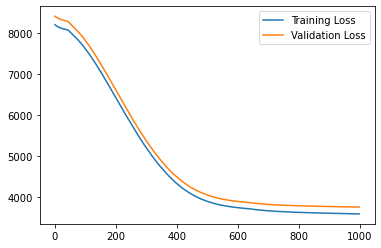

In [72]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [73]:
eval_model(X_train, y_train, nn_model)

MAE:  32.49041032809839
MSE:  3582.9916519087046
R2:  0.47630029609122937


In [74]:
eval_model(X_val, y_val, nn_model)

MAE:  33.4833146060769
MSE:  3749.914882000526
R2:  0.4639927772609608


In [75]:
eval_model(X_test, y_test, nn_model)

MAE:  33.14402131175222
MSE:  3780.4895238346085
R2:  0.4658324424437652


The model does not over or underfit but has a worse performance than the MLP Regressor, thus we use the MLP Regressor to fill in the missing values

In [76]:
best_model = mlp

# Filling in missing values

We now fill in the missing values of snow using the MLPRegressor model.

To ensure that the new values make sense, a short analysis will be done on the descriptive statistics of the features where there is a lot of snow. This will be compared to the filled in values.

In [77]:
stats_total = weather_df_total.describe()
stats_total

,tavg,tmin,tmax,prcp,snow,wspd,pres
count,21228.000000,21230.000000,21230.000000,17976.000000,10530.000000,21070.000000,18704.000000
mean,2.264033,-2.488780,7.113457,1.681976,36.199715,13.322947,1019.968199
std,10.762083,11.131696,11.086798,5.922205,83.396319,7.434906,7.352371
min,-39.200000,-44.000000,-36.700000,0.000000,0.000000,0.000000,969.300000
25%,-3.900000,-8.800000,0.000000,0.000000,0.000000,7.800000,1016.000000
50%,2.200000,-2.100000,6.800000,0.000000,0.000000,12.100000,1020.450000
75%,9.400000,4.400000,15.200000,0.200000,30.000000,17.600000,1024.800000
max,30.200000,28.600000,32.800000,107.700000,640.000000,50.400000,1043.100000


We narrow the data down to where there is more than 30 mm of snow

In [78]:
weather_df_total.query('snow > 30').describe()

,tavg,tmin,tmax,prcp,snow,wspd,pres
count,2168.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2060.000000
mean,-9.696587,-14.515945,-5.348433,2.030138,168.624147,14.857392,1019.969684
std,8.660996,9.627511,8.393271,5.078313,107.075759,8.289323,8.803566
min,-39.200000,-44.000000,-34.900000,0.000000,31.750000,0.000000,976.100000
25%,-15.400000,-20.600000,-10.600000,0.000000,80.000000,8.300000,1014.500000
50%,-8.450000,-13.800000,-3.200000,0.000000,130.000000,13.700000,1020.950000
75%,-2.700000,-7.000000,1.100000,1.400000,250.000000,20.300000,1026.500000
max,7.100000,5.000000,13.300000,63.200000,640.000000,41.800000,1037.700000


We see that the average temperature has fallen to -9.7 and the same decrease in temperature is also seen in the other temperature columns. The other columns seem to not have changed a significant amount.

We now fill in the missing values. First for 2019 and then 2020

## Fill for 2019

In [79]:
col_nan_ix = weather_df_2019['snow'].isna()

In [80]:
weather_no_snow = weather_df_2019[col_nan_ix][features]
weather_no_snow

,tmax,tavg,tmin
62,5.7,2.1,-1.6
63,2.3,-0.1,-2.1
64,3.4,1.4,0.1
65,10.1,3.1,-1.0
66,10.7,4.0,-2.1
...,...,...,...
10690,5.0,-0.9,-4.3
10691,3.3,-1.6,-5.5
10692,2.8,-2.8,-6.6
10693,4.4,-3.2,-8.2


In [81]:
weather_no_snow.isna().sum()

tmax    111
tavg    111
tmin    111
dtype: int64

Unfortunately, we have some missing values in the features used to predict the snow values, so we will have to drop these and not be able to fill out all missing values for snow

In [82]:
weather_no_snow = weather_no_snow.dropna()

In [83]:
predictions = best_model.predict(weather_no_snow)

In [84]:
predictions_series = pd.Series(predictions, name='snow', index=weather_no_snow.index)

In [85]:
predictions_series

62       -0.819755
63        0.977929
64       -0.819755
65       -0.819755
66       -0.819755
           ...    
10690    -0.540848
10691    -0.819755
10692    47.115279
10693    11.007853
10694    -0.819755
Name: snow, Length: 5350, dtype: float64

We remove negative values

In [86]:
predictions_series[predictions_series < 0] = 0
predictions_series

62        0.000000
63        0.977929
64        0.000000
65        0.000000
66        0.000000
           ...    
10690     0.000000
10691     0.000000
10692    47.115279
10693    11.007853
10694     0.000000
Name: snow, Length: 5350, dtype: float64

Now the missing values can be replaced by their predicted values

In [87]:
weather_df_2019_pred = weather_df_2019.copy()

In [88]:
weather_df_2019_pred.loc[col_nan_ix, 'snow'] = predictions_series

In [89]:
weather_df_2019_pred

,iata_code,DAY_OF_MONTH,tavg,tmin,tmax,prcp,snow,wspd,pres
0,GNV,1,20.1,13.9,27.8,0.0,0.0,4.0,1021.9
1,GNV,2,19.8,14.4,27.2,0.0,0.0,2.2,1019.3
2,GNV,3,20.6,15.6,27.2,0.0,0.0,7.6,1016.7
3,GNV,4,20.3,14.4,27.2,14.7,0.0,14.4,1014.1
4,GNV,5,13.4,7.2,16.1,0.0,0.0,12.2,1017.6
...,...,...,...,...,...,...,...,...,...
10721,LYH,27,0.0,-6.6,9.4,0.0,0.0,5.4,1018.5
10722,LYH,28,2.8,-2.1,8.3,0.0,0.0,4.7,1015.6
10723,LYH,29,2.6,-5.5,6.7,1.3,0.0,6.1,1011.5
10724,LYH,30,-3.6,-9.9,2.8,0.0,0.0,14.4,1017.9


In [90]:
weather_df_2019_pred.isna().sum()

iata_code          0
DAY_OF_MONTH       0
tavg             112
tmin             111
tmax             111
prcp            1738
snow             111
wspd             191
pres            1374
dtype: int64

In [91]:
weather_df_2019.isna().sum()

iata_code          0
DAY_OF_MONTH       0
tavg             112
tmin             111
tmax             111
prcp            1738
snow            5461
wspd             191
pres            1374
dtype: int64

We have managed to eliminate 5350 missing values of snow. The data is now merged again

In [92]:
df19_weather = df19.merge(weather_df_2019_pred.rename(rename_map('ORIGIN'), axis=1), on=['ORIGIN', 'DAY_OF_MONTH'])
df19_weather = df19_weather.merge(weather_df_2019_pred.rename(rename_map('DEST'), axis=1), on=['DEST', 'DAY_OF_MONTH'])

In [93]:
df19_weather.shape

(583985, 35)

In [94]:
df19_weather.isna().sum()

DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                  2543
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                 16352
DEP_DEL15                16355
DEP_TIME_BLK                 0
ARR_TIME                 17061
ARR_DEL15                18022
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
ORIGIN_tavg               2919
ORIGIN_tmin               2912
ORIGIN_tmax               2912
ORIGIN_prcp              26856
ORIGIN_snow               2912
ORIGIN_wspd               3952
ORIGIN_pres              24313
DEST_tavg                 2923
DEST_tmin                 2916
DEST_tmax                 2916
DEST_prcp                26875
DEST_sno

We now have much less missing values in the snow column. We went from 180000 missing rows to 2900.

## Fill for 2020

In [95]:
col_nan_ix = weather_df_2020['snow'].isna()

In [96]:
weather_no_snow = weather_df_2020[col_nan_ix][features]
weather_no_snow

,tmax,tavg,tmin
62,5.7,2.1,-1.6
63,2.3,-0.1,-2.1
64,3.4,1.4,0.1
65,10.1,3.1,-1.0
66,10.7,4.0,-2.1
...,...,...,...
10690,5.0,-0.9,-4.3
10691,3.3,-1.6,-5.5
10692,2.8,-2.8,-6.6
10693,4.4,-3.2,-8.2


In [97]:
weather_no_snow.isna().sum()

tmax    111
tavg    111
tmin    111
dtype: int64

Unfortunately, we have some missing values in the features used to predict the snow values, so we will have to drop these and not be able to fill out all missing values for snow

In [98]:
weather_no_snow = weather_no_snow.dropna()

In [99]:
predictions = best_model.predict(weather_no_snow)

In [100]:
predictions_series = pd.Series(predictions, name='snow', index=weather_no_snow.index)

In [101]:
predictions_series

62       -0.819755
63        0.977929
64       -0.819755
65       -0.819755
66       -0.819755
           ...    
10690    -0.540848
10691    -0.819755
10692    47.115279
10693    11.007853
10694    -0.819755
Name: snow, Length: 5350, dtype: float64

We remove negative values

In [102]:
predictions_series[predictions_series < 0] = 0
predictions_series

62        0.000000
63        0.977929
64        0.000000
65        0.000000
66        0.000000
           ...    
10690     0.000000
10691     0.000000
10692    47.115279
10693    11.007853
10694     0.000000
Name: snow, Length: 5350, dtype: float64

Now the missing values can be replaced by their predicted values

In [103]:
weather_df_2020_pred = weather_df_2020.copy()

In [104]:
weather_df_2020_pred.loc[col_nan_ix, 'snow'] = predictions_series

In [105]:
weather_df_2020_pred

,iata_code,DAY_OF_MONTH,tavg,tmin,tmax,prcp,snow,wspd,pres
0,GNV,1,20.1,13.9,27.8,0.0,0.0,4.0,1021.9
1,GNV,2,19.8,14.4,27.2,0.0,0.0,2.2,1019.3
2,GNV,3,20.6,15.6,27.2,0.0,0.0,7.6,1016.7
3,GNV,4,20.3,14.4,27.2,14.7,0.0,14.4,1014.1
4,GNV,5,13.4,7.2,16.1,0.0,0.0,12.2,1017.6
...,...,...,...,...,...,...,...,...,...
10721,LYH,27,0.0,-6.6,9.4,0.0,0.0,5.4,1018.5
10722,LYH,28,2.8,-2.1,8.3,0.0,0.0,4.7,1015.6
10723,LYH,29,2.6,-5.5,6.7,1.3,0.0,6.1,1011.5
10724,LYH,30,-3.6,-9.9,2.8,0.0,0.0,14.4,1017.9


In [106]:
weather_df_2020_pred.isna().sum()

iata_code          0
DAY_OF_MONTH       0
tavg             112
tmin             111
tmax             111
prcp            1738
snow             111
wspd             191
pres            1374
dtype: int64

In [107]:
weather_df_2020_pred.isna().sum()

iata_code          0
DAY_OF_MONTH       0
tavg             112
tmin             111
tmax             111
prcp            1738
snow             111
wspd             191
pres            1374
dtype: int64

We have managed to eliminate 5350 missing values of snow. The data is now merged again

In [108]:
df20_weather = df20.merge(weather_df_2020_pred.rename(rename_map('ORIGIN'), axis=1), on=['ORIGIN', 'DAY_OF_MONTH'])
df20_weather = df20_weather.merge(weather_df_2020_pred.rename(rename_map('DEST'), axis=1), on=['DEST', 'DAY_OF_MONTH'])

In [109]:
df20_weather.shape

(606497, 35)

In [110]:
df20_weather.isna().sum()

DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                   698
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                  6638
DEP_DEL15                 6671
DEP_TIME_BLK                 0
ARR_TIME                  7046
ARR_DEL15                 8043
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
ORIGIN_tavg               3232
ORIGIN_tmin               3225
ORIGIN_tmax               3225
ORIGIN_prcp              28496
ORIGIN_snow               3225
ORIGIN_wspd               4337
ORIGIN_pres              25972
DEST_tavg                 3236
DEST_tmin                 3229
DEST_tmax                 3229
DEST_prcp                28520
DEST_sno

We now have much less missing values in the snow column. We went from 190000 missing rows to 3200.

## Validation

We will now investigate how the descriptive statistics look with the imputed values

In [111]:
weather_df_total_pred = pd.concat([weather_df_2019_pred, weather_df_2020_pred]).reset_index(drop=True)

In [112]:
weather_df_total_pred.query('snow > 30').describe()

,tavg,tmin,tmax,prcp,snow,wspd,pres
count,5966.000000,5968.000000,5968.000000,4582.000000,5968.000000,5894.000000,5048.000000
mean,-9.326311,-14.104431,-4.906013,1.103939,656.582063,14.270946,1021.870443
std,7.530732,8.468860,7.268721,3.784094,684.256536,8.204766,8.379000
min,-39.200000,-44.000000,-36.700000,0.000000,30.305417,0.000000,972.900000
25%,-13.600000,-19.300000,-8.900000,0.000000,150.000000,8.100000,1017.300000
50%,-7.500000,-12.900000,-2.800000,0.000000,367.381828,13.000000,1023.100000
75%,-3.600000,-7.700000,0.100000,0.300000,977.219531,19.100000,1027.700000
max,7.100000,5.000000,13.300000,63.200000,3985.025517,49.000000,1043.100000


The table shows a slight increase in mean of the three temperature columns, which indicates that the model predicts snow in hotter temperatures. However, observing the 75% quantiles, we see that this is not the case, as these values are very close to the values from the original dataset. 

We can therefore assume that the model makes good predictions on there being snow, and this will have a great benefit over replacing the snow column with the mean, as that would result in all the missing rows having ~36 mm of snow, even in 20 degrees celsius.


We can now save the data

In [113]:
df19_weather.to_csv('Jan_2019_ontime_weather_imputed.csv', index=False)
df20_weather.to_csv('Jan_2020_ontime_weather_imputed.csv', index=False)